In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as pyplot
pyplot.style.use('ggplot')
pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['figure.figsize'] = [12,5]
matplotlib.rc('lines', linewidth=1, linestyle='-')

In C:\Users\crash\Miniconda3\envs\pcfixo\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\crash\Miniconda3\envs\pcfixo\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\crash\Miniconda3\envs\pcfixo\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\crash\Miniconda3\envs\pcfixo\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\crash\Miniconda3\envs\pcfixo

In [2]:
# load the csv file
# ../30min/30minstore290.csv
# ../30min/30minstore1027.csv
# ../30min/30minstore274.csv
# special case01: ../30min/partial_covid_stationary_sliced_30minstore274.csv
# special case02: ../30min/full_covid_nonstationary_sliced_30minstore274.csv
# predict covid:  ../30min/predict_covid_30minstore274
dataset = pd.read_csv('../30min/partial_covid_stationary_sliced_30minstore274.csv', header=0, infer_datetime_format=True,
                   parse_dates=['datetime'], index_col=['datetime'])

#dataset = dataset.drop(['store', 'products_sold', 'sales', 'weekday', 'year', 'day', 'month'], axis=1)
dataset = dataset[['clients_that_bought', 'halfhour']]

dataset = dataset.astype('float64')
dataset

,clients_that_bought,halfhour
datetime,,
2020-03-18 08:30:00,30.0,17.0
2020-03-18 09:00:00,41.0,18.0
2020-03-18 09:30:00,36.0,19.0
2020-03-18 10:00:00,26.0,20.0
2020-03-18 10:30:00,21.0,21.0
...,...,...
2020-05-26 18:30:00,17.0,37.0
2020-05-26 19:00:00,11.0,38.0
2020-05-26 19:30:00,15.0,39.0


In [3]:
def create_dataset(df, n_deterministic_features, window_size, forecast_size, batch_size, shifts):
    # Feel free to play with shuffle buffer size
    shuffle_buffer_size = len(df)
    # Total size of window is given by the number of steps to be considered
    # before prediction time + steps that we want to forecast
    total_size = window_size + forecast_size

    data = tf.data.Dataset.from_tensor_slices(df.values)

    # Selecting windows
    data = data.window(total_size, shift=shifts, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # Shuffling data (seed=Answer to the Ultimate Question of Life, the Universe, and Everything)
    #data = data.shuffle(shuffle_buffer_size, seed=42)

    # Extracting past features + deterministic future + labels
    data = data.map(lambda k: ((k[:-forecast_size],
                             k[-forecast_size:,-n_deterministic_features:]),
                             k[-forecast_size:,0]))

  
    return data.batch(batch_size)

In [4]:
# Times at which to split train/test
test_time = 1000

# How much data from the past should we need for a forecast?
window_len = 50 # Three weeks
# How far ahead do we want to generate forecasts?
forecast_len = 700 # Five days
shift = forecast_len
# Auxiliary constants
n_total_features = len(dataset.columns) 
n_deterministic_features = 1

# Splitting dataset into train/val/test
training_data = dataset.iloc[:test_time]
print(training_data.shape)
test_data = dataset.iloc[test_time:]
print(test_data.shape)

# Now we get training, validation, and test as tf.data.Dataset objects

batch_size = 5

training_windowed = create_dataset(training_data, n_deterministic_features, window_len, forecast_len, batch_size, 1)

test_windowed = create_dataset(test_data, n_deterministic_features, window_len, forecast_len, 1, shift)


(1000, 2)
(750, 2)


In [5]:
latent_dim = 32
n_epochs = 20

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = tf.keras.Input(shape=(window_len,n_total_features), name='past_inputs')
# Encoding the past
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(past_inputs)

future_inputs = tf.keras.Input(shape=(forecast_len,n_deterministic_features), name='future_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True)
x = decoder_lstm(future_inputs, 
                               initial_state=[state_h, state_c])

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(inputs=[past_inputs,future_inputs], outputs=output)

optimizer = tf.keras.optimizers.Adam() #experiment with different learning_rates
loss = tf.keras.losses.Huber()
model.compile(loss=loss, optimizer=optimizer, metrics=["mae","mape"])
print(model.summary())
history = model.fit(training_windowed,epochs=n_epochs)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
past_inputs (InputLayer)        [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
future_inputs (InputLayer)      [(None, 700, 1)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 32), (None,  4480        past_inputs[0][0]                
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 700, 32)      4352        future_inputs[0][0]              
                                                                 lstm[0][1]                   

In [6]:
model.evaluate(test_windowed)

1/1 [==============================] - 1s 1s/step - loss: 4.5173 - mae: 4.9973 - mape: 28.6593


[4.517307758331299, 4.997341156005859, 28.65927505493164]

(1, 700, 1)


C:\Users\crash\Miniconda3\envs\pcfixo\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


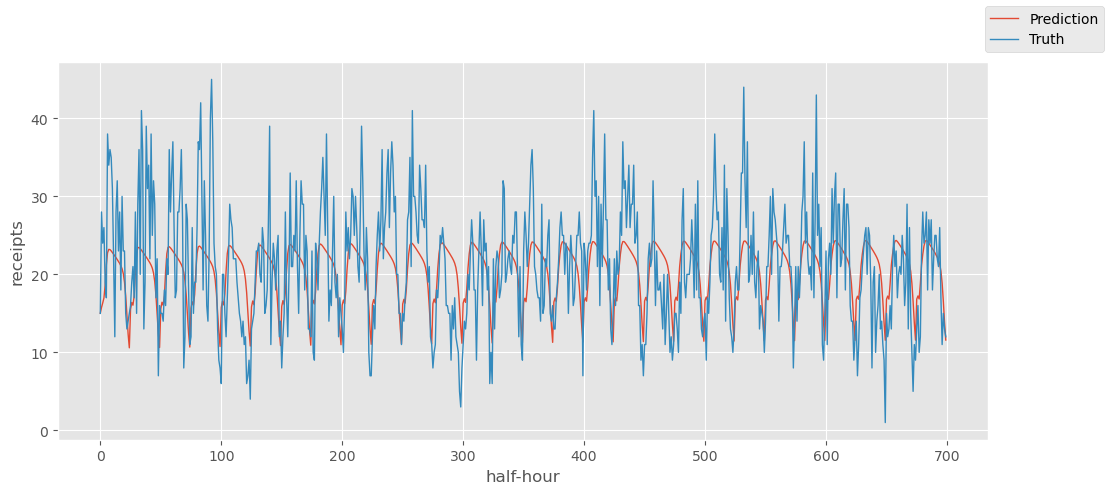

In [7]:

fig, ax = pyplot.subplots(nrows=1, ncols=1)

for i, data in enumerate(test_windowed.take(1)):
    (past, future), truth = data

    pred = model.predict((past,future)) 
    print(pred.shape)

    row = i//2
    col = i%2

    ax.plot(pred.flatten(), label='Prediction')
    ax.plot(truth.numpy().flatten(),label='Truth')

# Labeling axes
for i in range(1):
    ax.set_xlabel('half-hour')
for i in range(1):
    ax.set_ylabel('receipts')

handles, labels = ax.get_legend_handles_labels()
fig.subplots_adjust(wspace=0, hspace=0.5)
fig.legend(handles, labels, loc='upper right')

fig.show()

In [8]:
import tensorflow_probability as tfp
tfd = tfp.distributions
n_epochs=1200

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = tf.keras.Input(shape=(window_len,n_total_features), name='past_inputs')
# Encoding the past
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(past_inputs)

future_inputs = tf.keras.Input(shape=(forecast_len,n_deterministic_features), name='future_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True)
x = decoder_lstm(future_inputs, 
                               initial_state=[state_h, state_c])
#x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='relu')(x)
output = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., 0], scale=1e-3+tf.math.softplus(0.001*t[..., 1])), name='normal_dist')(x)

model = tf.keras.models.Model(inputs=[past_inputs,future_inputs], outputs=output)

negloglik = lambda y, p_y: -p_y.log_prob(y)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss=negloglik,
              optimizer=optimizer)
print(model.summary())
history = model.fit(training_windowed,epochs=n_epochs)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
past_inputs (InputLayer)        [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
future_inputs (InputLayer)      [(None, 700, 1)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 32), (None,  4480        past_inputs[0][0]                
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 700, 32)      4352        future_inputs[0][0]              
                                                                 lstm_2[0][1]               

51/51 [==============================] - 13s 263ms/step - loss: 36.5205
Epoch 75/1200
51/51 [==============================] - 11s 223ms/step - loss: 36.5227
Epoch 76/1200
51/51 [==============================] - 11s 224ms/step - loss: 36.4542
Epoch 77/1200
51/51 [==============================] - 12s 242ms/step - loss: 36.4656
Epoch 78/1200
51/51 [==============================] - 11s 223ms/step - loss: 36.4058
Epoch 79/1200
51/51 [==============================] - 12s 241ms/step - loss: 36.4278
Epoch 80/1200
51/51 [==============================] - 12s 236ms/step - loss: 36.3240
Epoch 81/1200
51/51 [==============================] - 12s 229ms/step - loss: 36.3287
Epoch 82/1200
51/51 [==============================] - 12s 239ms/step - loss: 36.3010
Epoch 83/1200
51/51 [==============================] - 12s 240ms/step - loss: 36.2967
Epoch 84/1200
51/51 [==============================] - 13s 255ms/step - loss: 36.2928
Epoch 85/1200
51/51 [==============================] - 12s 227ms/ste

KeyboardInterrupt: 

In [ ]:
%matplotlib notebook
mean = lambda x: x.mean().numpy().flatten()
sd = lambda x: x.stddev().numpy().flatten() 

t = np.array(range(forecast_len))

for i, data in enumerate(test_windowed.take(1)):
    (past, future), truth = data

    pred = model((past,future))
    print(pred.shape)
    pyplot.fill_between(t, 
                   mean(pred) + 1.96*sd(pred), 
                   (mean(pred) - 1.96*sd(pred)).clip(min=0),
                   color = 'green', label = '95% CI', alpha=0.2,
                   linewidth = 1)
    pyplot.plot(t,mean(pred), label='Prediction', color='red')
    pyplot.plot(t,truth.numpy().flatten(),label='True value', alpha=0.5, color="blue")

pyplot.show()